# Countries Explorative Data Analysis (EDA)

In [3]:
from bs4 import BeautifulSoup
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import time

## Overview
The dataset used in this project contains information about all the countries in the world.
The objective of the analysis is to gain insights about different details such as population, area, distribution of wealth and life expentancy.

## Questions for Analysis

1. What are the 10 most populated countries?
2. What are the top 3 most populated countries by continent?
3. What is the most populated continent?
4. What are the top 20 largest countries?
5. What is the smallest continent?
6. What is the proportion of countries driving on the left vs. right side?
7. What are the top 5 most common languages?
8. - What are the 5 countries with the most inequalities?
   - What are the 5 countries with the least inequalities? 
9. What is the average and median life expectancy per continent?
10. Do the GINI Index and the GDP per capita have an impact life expectancy?

## About Dataset

The dataset comes from a REST API and 2 websites
- [REST Countries API](https://restcountries.com/)
- [World Bank Group](https://datacatalog.worldbank.org/search/dataset/0038130)
- [Worldometer](https://www.worldometers.info/demographics/life-expectancy/)

### Columns description
- ```name```: country name
- ```code```: ISO 3166 country code
- ```continent```: continent of the country
- ```area```: country area, in $km^{2}$
- ```car_side```: left- or right-hand traffic
- ```population```: population of the country
- ```gini```: GINI Coefficient or GINI Index. It measures inequality on a scale from 0 to 100, 0 being perfect equality and 100 being perfect inequality.
- ```languages```: languages spoken
- ```gdp```: Gross Domestic Product (GDP), in millions of US Dollars
- ```life_expentancy```: life expentancy for both sexes
- ```gdp_per_capita```: Gross Domestic Product per Capita (100,000 people)

## Step 1 - Data Collection

### Create countries CSV file from API

In [9]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(5):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        else:
            countriesJson = json.loads(response.content)
    
            # Collect relevant columns
            for item in countriesJson:
                keys = item.keys()
                country = {
                    'name': item['name']['common'],
                    'cca3': item['cca3'],
                    'continent' : item['continents'][0],
                    'area': item['area'],
                    'car_side': item['car']['side'],
                    'population': item['population'],
                    'gini': list(item['gini'].values())[0] if 'gini' in keys else None,
                    'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None
                }
                country_list.append(country)
    
            header = country_list[0].keys()
    
            # Create/replace CSV file
            with open('Data/countries.csv', 'w', newline='') as output_file:
                dict_writer = csv.DictWriter(output_file, header)
                dict_writer.writeheader()
                dict_writer.writerows(country_list)
                output_file.close()
                print('CSV file', output_file.name, 'created')
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API')

Failed to fetch data from REST countries API


### Create Life Expentancy CSV through Web Scraping

In [11]:
# Scrape the table
response = requests.get('https://www.worldometers.info/demographics/life-expectancy/')

if response.status_code != 200:
    print('Failed to fetch data.')
else:
    soup = BeautifulSoup(response.content)
    life_exp_table = soup.find('table', {'id': 'example2'})
    
    # Save the data into a dictionary
    life_exp_list = []
    
    # header
    table_header = life_exp_table.select('thead tr th')
    keys = list(map(lambda x: x.text, table_header))
    
    # body
    table_rows = life_exp_table.find('tbody').find_all('tr')
    
    for row in table_rows:
        table_data = row.select('td')
        row_data = np.array(list(map(lambda x: x.text, table_data)))
        dict_item = {}
        
        for i in range(len(row_data)):
            dict_item[keys[i]] = row_data[i]
        
        life_exp_list.append(dict_item)

  
    # Create/replace CSV file
    with open('Data/life_expectancy.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(life_exp_list)
        output_file.close()
        print('CSV file', output_file.name, 'created')

CSV file Data/life_expectancy.csv created


### Create dataframe from the 3 CSV files

In [13]:
# Get number of rows/columns of each dataframe
countries = pd.read_csv('Data/countries.csv')
print('Countries shape:', countries.shape)

gdp = pd.read_csv('Data/GDP.csv', on_bad_lines='error')
print('GDP shape:', gdp.shape)

life_expectancy = pd.read_csv('Data/life_expectancy.csv')
print('Life Expectancy shape:', life_expectancy.shape)

Countries shape: (250, 8)
GDP shape: (217, 4)
Life Expectancy shape: (201, 5)


In [14]:
# Merge dataframes
countries = countries.merge(right=gdp, how='inner', left_on='cca3', right_on='code')
countries = countries.merge(right=life_expectancy, how='inner', left_on='name', right_on='Country')
print('Merged dataframe shape:', countries.shape)

Merged dataframe shape: (184, 17)


## Step 2 - Data Exploration

In [16]:
# Remove scientific notation and keep 2 decimals
pd.options.display.float_format = '{:.2f}'.format 

In [17]:
countries.head()

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp,#,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
0,Grenada,GRD,North America,344.00,left,112519,NaN,English,GRD,193.00,Grenada,"1,320",93,Grenada,75.37,78.50,72.52
1,Switzerland,CHE,Europe,41284.00,right,8654622,33.10,"French, Swiss German, Italian, Romansh",CHE,20.00,Switzerland,"884,940",5,Switzerland,84.09,85.95,82.17
2,Sierra Leone,SLE,Africa,71740.00,right,7976985,35.70,English,SLE,169.00,Sierra Leone,"3,810",189,Sierra Leone,61.96,63.70,60.23
3,Hungary,HUN,Europe,93028.00,right,9749763,29.60,Hungarian,HUN,56.00,Hungary,"212,389",73,Hungary,77.18,80.33,73.89
4,Barbados,BRB,North America,430.00,left,287371,NaN,English,BRB,162.00,Barbados,"6,394",81,Barbados,76.33,78.76,73.75


In [18]:
countries.tail()

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp,#,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
179,Portugal,PRT,Europe,92090.00,right,10305564,33.50,Portuguese,PRT,48.00,Portugal,"287,080",22,Portugal,82.55,85.25,79.68
180,Belgium,BEL,Europe,30528.00,right,11555997,27.20,"German, French, Dutch",BEL,23.00,Belgium,"632,217",26,Belgium,82.27,84.45,80.06
181,Israel,ISR,Asia,20770.00,right,9216900,39.00,"Arabic, Hebrew",ISR,28.00,Israel,"509,901",19,Israel,82.73,84.71,80.67
182,New Zealand,NZL,Oceania,270467.00,left,5084300,NaN,"English, Māori, New Zealand Sign Language",NZL,51.00,New Zealand,"253,466",27,New Zealand,82.25,83.89,80.60
183,Nicaragua,NIC,North America,130373.00,right,6624554,46.20,Spanish,NIC,127.00,Nicaragua,"17,829",96,Nicaragua,75.10,77.58,72.46


In [19]:
countries.sample(5)

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp,#,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
44,Algeria,DZA,Africa,2381741.00,right,44700000,27.60,Arabic,DZA,53.00,Algeria,"239,899",80,Algeria,76.48,77.91,75.10
3,Hungary,HUN,Europe,93028.00,right,9749763,29.60,Hungarian,HUN,56.00,Hungary,"212,389",73,Hungary,77.18,80.33,73.89
91,Thailand,THA,Asia,513120.00,left,69799978,34.90,Thai,THA,27.00,Thailand,"514,945",78,Thailand,76.56,80.98,72.34
182,New Zealand,NZL,Oceania,270467.00,left,5084300,NaN,"English, Māori, New Zealand Sign Language",NZL,51.00,New Zealand,"253,466",27,New Zealand,82.25,83.89,80.60
109,Togo,TGO,Africa,56785.00,right,8278737,43.10,French,TGO,152.00,Togo,"9,171",185,Togo,62.93,63.15,62.70


In [20]:
countries.dtypes

name                               object
cca3                               object
continent                          object
area                              float64
car_side                           object
population                          int64
gini                              float64
languages                          object
code                               object
rank                              float64
country                            object
gdp                                object
#                                   int64
Country                            object
Life Expectancy  (both sexes)     float64
Females  Life Expectancy          float64
Males  Life Expectancy            float64
dtype: object

In [21]:
countries.describe()

,area,population,gini,rank,#,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
count,184.00,184.00,159.00,178.00,184.00,184.00,184.00,184.00
mean,721311.55,41842131.01,38.13,94.37,101.84,73.60,76.20,71.02
std,1958072.95,149772100.69,7.81,57.15,57.87,7.06,7.19,7.04
min,180.00,97928.00,24.60,1.00,1.00,54.64,54.94,53.36
25%,27996.75,2509853.00,32.75,45.50,52.75,68.50,71.02,66.22
50%,137545.00,9468251.50,36.80,91.50,103.50,74.56,77.44,70.87
75%,580775.25,31118567.50,42.45,139.75,152.25,78.77,81.62,75.88
max,17098242.00,1402112000.00,63.00,205.00,200.00,85.63,88.26,82.97


In [22]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            184 non-null    object 
 1   cca3                            184 non-null    object 
 2   continent                       184 non-null    object 
 3   area                            184 non-null    float64
 4   car_side                        184 non-null    object 
 5   population                      184 non-null    int64  
 6   gini                            159 non-null    float64
 7   languages                       184 non-null    object 
 8   code                            184 non-null    object 
 9   rank                            178 non-null    float64
 10  country                         184 non-null    object 
 11  gdp                             184 non-null    object 
 12  #                               184 

## Step 3 - Data Preparation

In [24]:
# Drop the country column of the second and third dataframe
countries = countries.drop(['country', 'Country'], axis=1)
countries.sample(5)

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,gdp,#,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
50,Georgia,GEO,Asia,69700.00,right,3714000,35.90,Georgian,GEO,108.00,"30,536",101,74.66,79.23,69.75
135,Jordan,JOR,Asia,89342.00,right,10203140,33.70,Arabic,JOR,89.00,"50,814",59,77.98,80.34,75.89
130,Central African Republic,CAF,Africa,622984.00,right,4829764,56.20,"French, Sango",CAF,180.00,"2,555",198,57.67,59.56,55.51
41,Greece,GRC,Europe,131990.00,right,10715549,32.90,Greek,GRC,54.00,"238,206",32,82.03,84.46,79.50
83,Slovenia,SVN,Europe,20273.00,right,2100126,24.60,Slovene,SVN,85.00,"68,217",35,81.78,84.47,79.11


In [25]:
# Drop the code column of the second dataframe
countries = countries.drop('code', axis=1).rename(columns={'cca3': 'code'})
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,rank,gdp,#,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy
151,Ecuador,ECU,South America,276841.00,right,17643060,45.70,Spanish,63.00,"118,845",66,77.58,80.31,74.88
7,Benin,BEN,Africa,112622.00,right,12123198,47.80,French,123.00,"19,673",192,60.96,62.42,59.52
86,Iceland,ISL,Europe,103000.00,right,366425,26.10,Icelandic,105.00,"31,020",17,83.01,84.47,81.63
111,Rwanda,RWA,Africa,26338.00,right,12952209,43.70,"English, French, Kinyarwanda",140.00,"14,098",154,68.02,70.14,65.71
72,Cuba,CUB,North America,109884.00,right,11326616,NaN,Spanish,NaN,,56,78.26,80.68,75.86


In [26]:
# Drop the rank, #, female and male life expentancy columns and rename life expectancy column
print(countries.columns)

Index(['name', 'code', 'continent', 'area', 'car_side', 'population', 'gini',
       'languages', 'rank', 'gdp', '#', 'Life Expectancy  (both sexes) ',
       'Females  Life Expectancy ', 'Males  Life Expectancy'],
      dtype='object')


In [27]:
countries = countries.drop(['rank', '#', 'Females  Life Expectancy ', 'Males  Life Expectancy'], axis=1)
countries = countries.rename(columns={'Life Expectancy  (both sexes) ': 'life_expectancy'})
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp,life_expectancy
92,Haiti,HTI,North America,27750.00,right,11402533,41.10,"French, Haitian Creole","19,851",65.12
132,Eritrea,ERI,Africa,117600.00,right,5352000,NaN,"Arabic, English, Tigrinya",,68.89
45,Netherlands,NLD,Europe,41850.00,right,16655799,28.10,Dutch,"1,118,125",82.30
131,Burkina Faso,BFA,Africa,272967.00,right,20903278,35.30,French,"20,325",61.29
3,Hungary,HUN,Europe,93028.00,right,9749763,29.60,Hungarian,"212,389",77.18


In [28]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries['car_side'] = countries['car_side'].str.strip()
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp,life_expectancy
33,Finland,FIN,Europe,338424.00,right,5530719,27.30,"Finnish, Swedish","300,187",82.08
41,Greece,GRC,Europe,131990.00,right,10715549,32.90,Greek,"238,206",82.03
104,Suriname,SUR,South America,163820.00,left,586634,57.90,Dutch,"3,782",73.76
21,Uzbekistan,UZB,Asia,447400.00,right,34232050,35.30,"Russian, Uzbek","90,889",72.53
76,Cyprus,CYP,Europe,9251.00,left,1207361,32.70,"Greek, Turkish","32,230",81.82


In [29]:
# Convert gdp column to float, NaN if empty
countries['gdp'] = countries['gdp'] \
    .str.replace(',', '') \
    .replace(r'^\s*$', np.nan, regex=True) \
    .astype('float')

In [30]:
# Inspect data after cleaning
countries.dtypes

name                object
code                object
continent           object
area               float64
car_side            object
population           int64
gini               float64
languages           object
gdp                float64
life_expectancy    float64
dtype: object

In [31]:
# Remove rows with null gini and gdp values
countries = countries.dropna(subset=['gini', 'gdp'])

In [32]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 183
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             156 non-null    object 
 1   code             156 non-null    object 
 2   continent        156 non-null    object 
 3   area             156 non-null    float64
 4   car_side         156 non-null    object 
 5   population       156 non-null    int64  
 6   gini             156 non-null    float64
 7   languages        156 non-null    object 
 8   gdp              156 non-null    float64
 9   life_expectancy  156 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 13.4+ KB


In [33]:
countries.describe()

,area,population,gini,gdp,life_expectancy
count,156.00,156.00,156.00,156.00,156.00
mean,800504.53,47754580.31,38.06,644166.35,73.17
std,2106073.03,161951736.80,7.85,2679104.77,7.07
min,300.00,98462.00,24.60,279.00,54.64
25%,40561.50,2930306.50,32.70,15984.75,67.75
50%,172427.00,10254352.00,36.80,55350.50,73.68
75%,591155.75,34901677.00,42.15,353956.00,78.03
max,17098242.00,1402112000.00,63.00,27360935.00,84.85


In [34]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head(5)

,name,code,continent,area,car_side,population,gini,languages,gdp,life_expectancy
0,Albania,ALB,Europe,28748.00,right,2837743,33.20,Albanian,22978.00,79.78
1,Algeria,DZA,Africa,2381741.00,right,44700000,27.60,Arabic,239899.00,76.48
2,Angola,AGO,Africa,1246700.00,right,32866268,51.30,Portuguese,84723.00,64.81
3,Argentina,ARG,South America,2780400.00,right,45376763,42.90,"Guaraní, Spanish",640591.00,77.54
4,Armenia,ARM,Asia,29743.00,right,2963234,29.90,Armenian,24212.00,75.85


In [35]:
countries.tail()

,name,code,continent,area,car_side,population,gini,languages,gdp,life_expectancy
151,Uzbekistan,UZB,Asia,447400.00,right,34232050,35.30,"Russian, Uzbek",90889.00,72.53
152,Vanuatu,VUT,Oceania,12189.00,right,307150,37.60,"Bislama, English, French",1126.00,71.65
153,Vietnam,VNM,Asia,331212.00,right,97338583,35.70,Vietnamese,429717.00,74.74
154,Zambia,ZMB,Africa,752612.00,left,18383956,57.10,English,28163.00,66.53
155,Zimbabwe,ZWE,Africa,390757.00,left,14862927,50.30,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",26538.00,63.06


In [36]:
# Add new column named GDP per Capita (per 100,000 people)
countries['gdp_per_capita'] = countries['gdp'] / countries['population'] * 100000
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp,life_expectancy,gdp_per_capita
152,Vanuatu,VUT,Oceania,12189.00,right,307150,37.60,"Bislama, English, French",1126.00,71.65,366.60
103,North Macedonia,MKD,Europe,25713.00,right,2077132,33.00,Macedonian,14761.00,77.54,710.64
89,Micronesia,FSM,Oceania,702.00,right,115021,40.10,English,460.00,71.64,399.93
8,Bangladesh,BGD,Asia,147570.00,left,164689383,32.40,Bengali,437415.00,74.93,265.60
7,Azerbaijan,AZE,Europe,86600.00,right,10110116,26.60,Azerbaijani,72356.00,74.58,715.68


## Step 4 - Data Analysis

#### Q1 - What are the 10 most populated countries?

In [39]:
# Data
top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')
top_10_pop_countries

,population
name,
China,1402112000
India,1380004385
United States,329484123
Indonesia,273523621
Pakistan,220892331
Brazil,212559409
Nigeria,206139587
Bangladesh,164689383
Russia,144104080


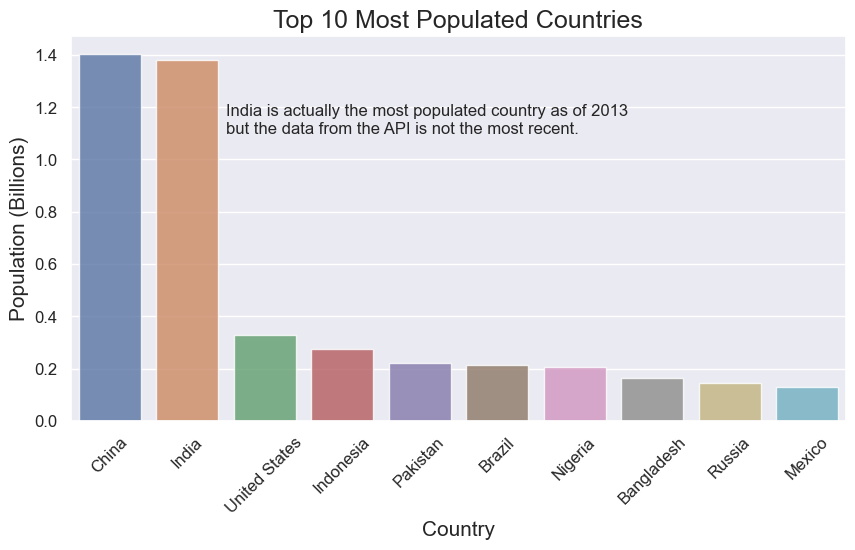

In [40]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# annotate plot
ax.text(1.5, 1100000000, "India is actually the most populated country as of 2013\nbut the data from the API is not the most recent.")

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

#### Q2 - What are the top 3 most populated countries by continent?

In [42]:
countries \
    .sort_values(by=['continent', 'population'], ascending=[True, False]) \
    .groupby('continent') \
    .head(3)[['continent', 'name', 'population']] \
    .reset_index(drop=True)

,continent,name,population
0,Africa,Nigeria,206139587
1,Africa,Ethiopia,114963583
2,Africa,DR Congo,108407721
3,Asia,China,1402112000
4,Asia,India,1380004385
5,Asia,Indonesia,273523621
6,Europe,Russia,144104080
7,Europe,Turkey,84339067
8,Europe,Germany,83240525
9,North America,United States,329484123


#### Q3 - What is the most populated continent?

In [44]:
# Data
total_pop_by_continent = countries \
    .groupby('continent')[['population']] \
    .sum() \
    .sort_values(by='population', ascending=False)
total_pop_by_continent

,population
continent,
Asia,4304931716
Africa,1302830016
Europe,828356539
North America,572897031
South America,402202650
Oceania,38496577


In [45]:
# Answer
most_populated_continent = total_pop_by_continent.head(1)
print('The most populated continent is', most_populated_continent.index[0], 'with', most_populated_continent.iloc[0,0], 'people.')

The most populated continent is Asia with 4304931716 people.


#### Q4 - What are the top 20 largest countries?

In [47]:
# Data
top_20_largest_countries = countries \
    .nlargest(n=20, columns='area')[['name', 'area']] \
    .set_index('name')
top_20_largest_countries

,area
name,
Russia,17098242.00
Canada,9984670.00
China,9706961.00
United States,9372610.00
Brazil,8515767.00
Australia,7692024.00
India,3287590.00
Argentina,2780400.00
Kazakhstan,2724900.00


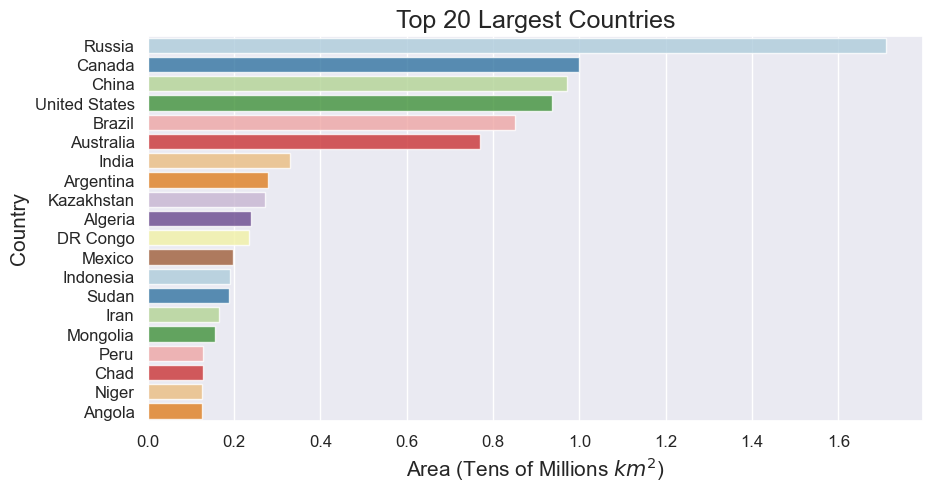

In [48]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_20_largest_countries,
                 x=top_20_largest_countries['area'],
                 y=top_20_largest_countries.index,
                 hue=top_20_largest_countries.index,
                 alpha=0.8,
                 palette='Paired',
                 orient='h')

# labels
ax.set_title('Top 20 Largest Countries', fontsize=18)
ax.set_xlabel('Area (Tens of Millions $km^2$)')
ax.set_ylabel('Country')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

# remove scientific notation showing at the end of the x axis
ax.xaxis.offsetText.set_visible(False)

plt.show()

#### Q5 - What is the smallest continent?

In [50]:
# Data
total_area_by_continent = countries \
    .groupby('continent')[['area']] \
    .sum() \
    .sort_values(by='area')
total_area_by_continent

,area
continent,
Oceania,8234899.00
South America,16821230.00
North America,21937091.00
Europe,23798851.00
Africa,26854682.00
Asia,27231953.00


In [51]:
# Answer
smallest_continent = total_area_by_continent.head(1)
print('The smallest continent is', smallest_continent.index[0], 'which is', round(smallest_continent.iloc[0,0]), 'square kilometers.')

The smallest continent is Oceania which is 8234899 square kilometers.


#### Q6 - What is the proportion of countries driving on the left vs. right side?

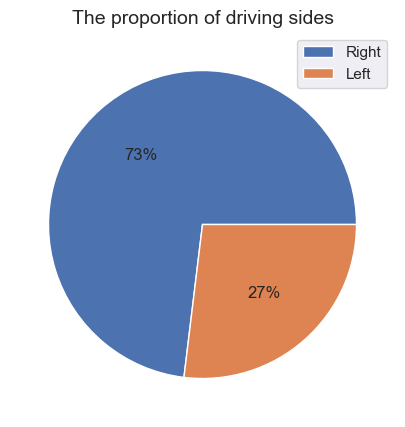

In [53]:
# Visualization
driving_sides = countries['car_side'].value_counts()
plt.pie(driving_sides, autopct='%.0f%%')
plt.title('The proportion of driving sides', fontsize=14)
plt.legend(labels=driving_sides.index.str.title())
plt.show()

### Languages

#### Q7 - What are the top 5 most common languages?

In [56]:
# Data
top_languages = countries['languages'].str.split(', ', expand=True).stack().value_counts().nlargest(n=5)
top_languages = pd.DataFrame(top_languages).rename(columns={'count': 'Number of Countries'})
top_languages

,Number of Countries
English,45
French,27
Spanish,18
Arabic,16
Russian,7


#### Q8A - What are the 5 countries with the most inequalities?

In [58]:
top_5_inequal_countries = countries.nlargest(n=5, columns='gini')[['name', 'continent', 'gini']]
top_5_inequal_countries

,name,continent,gini
126,South Africa,Africa,63.00
97,Namibia,Africa,59.10
131,Suriname,South America,57.90
154,Zambia,Africa,57.10
23,Central African Republic,Africa,56.20


#### Q8B - What are the 5 countries with the least inequalities?

In [60]:
top_5_equal_countries = countries.nsmallest(n=5, columns='gini')[['name', 'continent', 'gini']]
top_5_equal_countries

,name,continent,gini
123,Slovenia,Europe,24.60
122,Slovakia,Europe,25.00
9,Belarus,Europe,25.30
91,Moldova,Europe,25.70
147,United Arab Emirates,Asia,26.00


#### Q9 - What is the average and median life expectancy by continent?

In [62]:
# Data
countries.groupby('continent').agg({'life_expectancy': ['mean', 'median']})

life_expectancy       
                         mean median
continent                           
Africa                  65.42  65.25
Asia                    74.97  74.59
Europe                  79.71  81.45
North America           74.81  73.74
Oceania                 71.16  71.64
South America           75.77  77.54

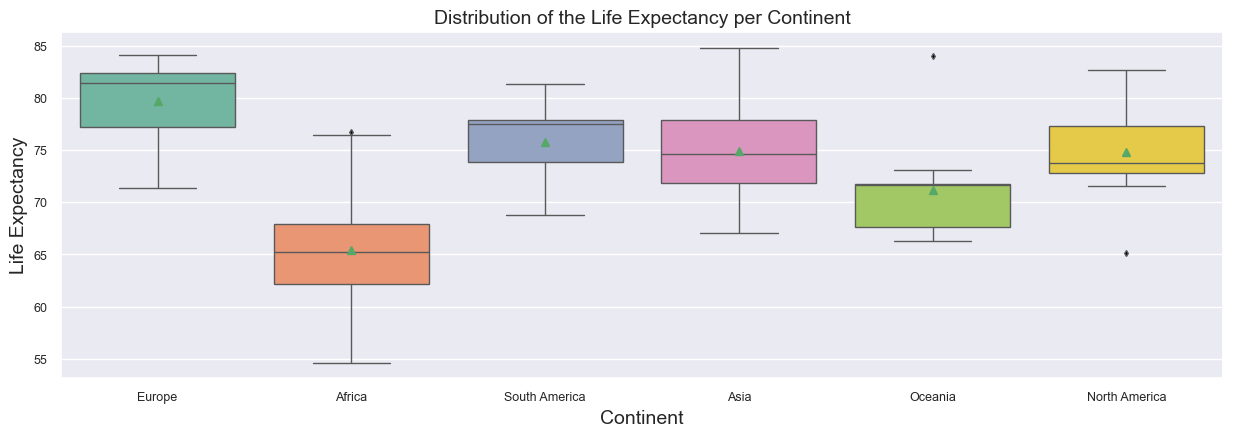

In [63]:
# Visualization

# plot
flierprops = dict(marker='d', markersize=3, markerfacecolor='black')
sns.set(rc={'figure.figsize': (15, 4.5)})
ax = sns.boxplot(data=countries,
                 x='continent',
                 y='life_expectancy',
                 hue='continent',
                 flierprops=flierprops,
                 showmeans=True,
                 palette='Set2')

# labels
ax.set_title('Distribution of the Life Expectancy per Continent', fontsize=14)
ax.set_xlabel('Continent')
ax.set_ylabel('Life Expectancy')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', labelsize=9)

plt.show()

#### Q12 - Is there a correlation between the GDP per capita and the GINI Index?

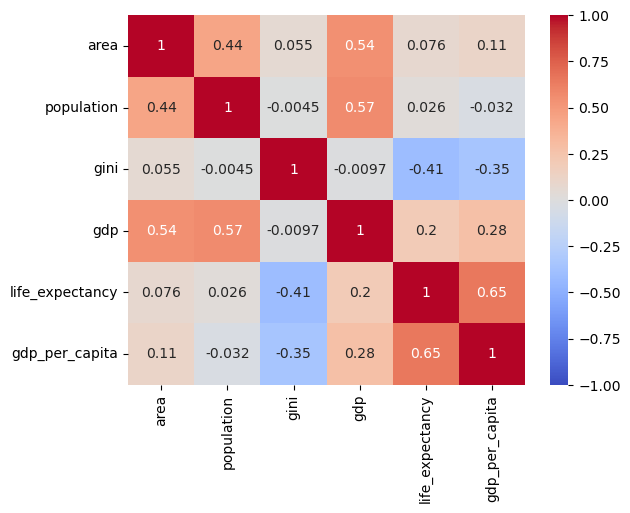

In [65]:
# Display correlation
sns.reset_orig() # prevent plot to be the same size as the previous one
corr_table = countries.corr(numeric_only=True)
sns.heatmap(corr_table, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

There seems to be a moderate (-0.41) correlation between the GINI Index and the Life Expectancy, and a strong (0.65) correlation between the GDP per Capita and the Life Expectancy.

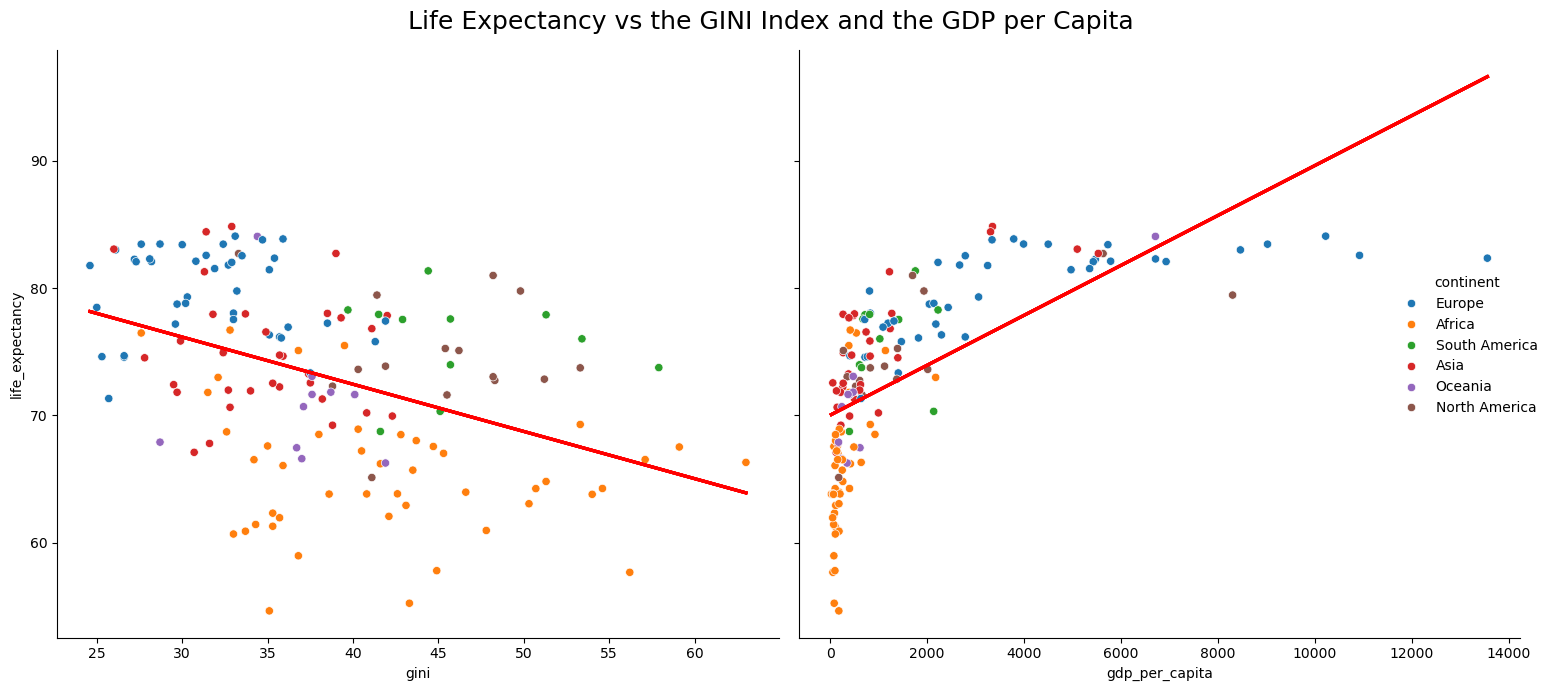

In [67]:
# Display plot of Life Expectancy over the 2 variables

# plot
ax = sns.pairplot(data=countries,
             x_vars=['gini', 'gdp_per_capita'],
             y_vars=['life_expectancy'],
             hue='continent',
             height=7)
ax.fig.suptitle('Life Expectancy vs the GINI Index and the GDP per Capita', fontsize=18)

# define function to plot a single regression line
def regline(x, y, **kwargs):
    sns.regplot(data=kwargs['data'], x=x.name, y=y.name, scatter=False, color=kwargs['color'], ci=None)

# call the function for each non-diagonal subplot within pairplot
ax.map_offdiag(regline, color='red', data=countries)

plt.tight_layout()
plt.show()

On the left plot we can see that the life expectancy decreases when the GINI index increases, and most countries with the smallest life expectancy are from Africa.

On the right plot, we see that the life expectancy increases when the GDP per capita increases, and the countries with the highest life expectancy are from Europe.

We can say that higher income and better wealth distribution increases quality of life, which usually means a longer life.

## End